<a href="https://colab.research.google.com/github/syedfaizal04/SAR-Despeckling-Dataset/blob/main/Improvd_accuracy_Despeckle_dataset_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Install Kaggle
!pip install -q kaggle

# Upload your kaggle.json API key
from google.colab import files
files.upload()

# Create Kaggle directory and move kaggle.json there
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [1]:
!kaggle datasets download -d javidtheimmortal/sar-despeckling-dataset --unzip

Dataset URL: https://www.kaggle.com/datasets/javidtheimmortal/sar-despeckling-dataset
License(s): apache-2.0
 99% 969M/974M [00:18<00:00, 80.0MB/s]
100% 974M/974M [00:18<00:00, 55.0MB/s]


In [6]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
base_dir = '/content/Main folder'
train_dir = os.path.join(base_dir, '/content/SAR despeckling filters dataset/Main folder/GTruth')
val_dir = os.path.join(base_dir, '/content/SAR despeckling filters dataset/Main folder/GTruth_val')
noisy_train_dir = os.path.join(base_dir, '/content/SAR despeckling filters dataset/Main folder/Noisy')
noisy_val_dir = os.path.join(base_dir, '/content/SAR despeckling filters dataset/Main folder/Noisy_val')

# Check the dataset structure
print(f'Train Images: {len(os.listdir(train_dir))}')
print(f'Validation Images: {len(os.listdir(val_dir))}')
print(f'Noisy Train Images: {len(os.listdir(noisy_train_dir))}')
print(f'Noisy Validation Images: {len(os.listdir(noisy_val_dir))}')


Train Images: 1500
Validation Images: 100
Noisy Train Images: 1500
Noisy Validation Images: 100


In [ ]:
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# ImagePairGenerator class to handle loading noisy and truth images
class ImagePairGenerator(tf.keras.utils.Sequence):
    def __init__(self, noisy_dir, truth_dir, batch_size=32, target_size=(256, 256), shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.noisy_dir = noisy_dir
        self.truth_dir = truth_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.noisy_images = sorted(os.listdir(noisy_dir))
        self.truth_images = sorted(os.listdir(truth_dir))
        self.indexes = np.arange(len(self.noisy_images))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.noisy_images) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        noisy_batch = []
        truth_batch = []

        for idx in batch_indexes:
            noisy_image_path = os.path.join(self.noisy_dir, self.noisy_images[idx])
            truth_image_path = os.path.join(self.truth_dir, self.truth_images[idx])
            noisy_img = load_img(noisy_image_path, target_size=self.target_size, color_mode='grayscale')
            truth_img = load_img(truth_image_path, target_size=self.target_size, color_mode='grayscale')
            noisy_img = img_to_array(noisy_img) / 255.0
            truth_img = img_to_array(truth_img) / 255.0
            noisy_batch.append(noisy_img)
            truth_batch.append(truth_img)

        return np.array(noisy_batch), np.array(truth_batch)

# Define paths to your dataset
noisy_train_dir = '/content/SAR despeckling filters dataset/Main folder/Noisy'  # Noisy training images
truth_train_dir = '/content/SAR despeckling filters dataset/Main folder/GTruth'  # Ground truth training images

noisy_val_dir = '/content/SAR despeckling filters dataset/Main folder/Noisy_val'  # Noisy validation images
truth_val_dir = '/content/SAR despeckling filters dataset/Main folder/GTruth_val'  # Ground truth validation images

# Initialize ImagePairGenerator instances
train_generator = ImagePairGenerator(noisy_train_dir, truth_train_dir, batch_size=32, target_size=(256, 256), shuffle=True)
val_generator = ImagePairGenerator(noisy_val_dir, truth_val_dir, batch_size=32, target_size=(256, 256), shuffle=False)

# Define the model architecture
model = Sequential([
    # Encoder
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Decoder
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),

    # Output layer
    Conv2D(1, (3, 3), activation='sigmoid', padding='same')
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Define ModelCheckpoint and EarlyStopping callbacks
checkpoint = ModelCheckpoint('/content/drive/MyDrive/saved_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    verbose=1,
    callbacks=[checkpoint, early_stopping]
)

# Save the model
model.save('/content/drive/MyDrive/saved_model.keras')

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 551ms/step - loss: 0.0311
Epoch 1: val_loss improved from inf to 0.01109, saving model to /content/drive/MyDrive/saved_model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 60s 743ms/step - loss: 0.0308 - val_loss: 0.0111
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - loss: 0.0045
Epoch 2: val_loss improved from 0.01109 to 0.00798, saving model to /content/drive/MyDrive/saved_model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 33s 624ms/step - loss: 0.0044 - val_loss: 0.0080
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - loss: 0.0036
Epoch 3: val_loss improved from 0.00798 to 0.00683, saving model to /content/drive/MyDrive/saved_model.keras
46/46 ━━━━━━━━━━━━━━━━━━━━ 40s 589ms/step - loss: 0.0036 - val_loss: 0.0068
Epoch 4/50
26/46 ━━━━━━━━━━━━━━━━━━━━ 12s 622ms/step - loss: 0.0034

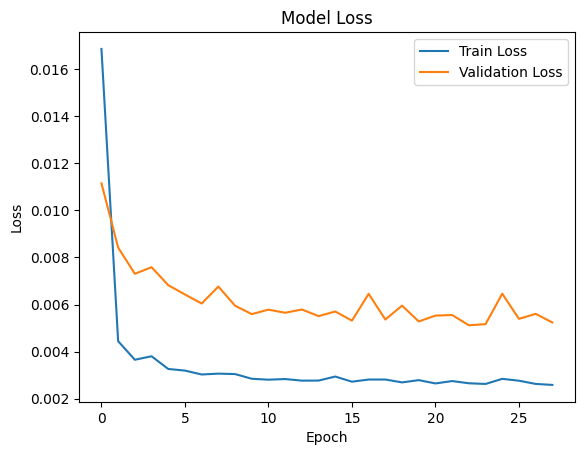

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Save the plot as a PNG file
plot_path = '/content/plot_loss.png'
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save the plot to the specified path
plt.savefig(plot_path)

# Display the plot
plt.show()

# If you're using Google Colab, you can directly download it
from google.colab import files
files.download(plot_path)  # This will trigger the download


In [ ]:
test_loss = model.evaluate(ImagePairGenerator(noisy_val_dir, truth_val_dir))
print(f"Test Loss (MSE): {test_loss:.4f}")


In [4]:
sample_image_path = '/content/SAR despeckling filters dataset/Main folder/Noisy/0_24576.tiff'
sample_image = load_img(sample_image_path, target_size=(256, 256), color_mode='grayscale')
sample_image_array = img_to_array(sample_image) / 255.0
sample_image_array = np.expand_dims(sample_image_array, axis=0)

predicted_image = model.predict(sample_image_array)
predicted_image = np.squeeze(predicted_image)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Noisy Image')
plt.imshow(sample_image_array[0, :, :, 0], cmap='gray')
plt.subplot(1, 2, 2)
plt.title('Despeckled Image')
plt.imshow(predicted_image, cmap='gray')
plt.show()


NameError: name 'load_img' is not defined